# Exporting American Movie Box Office Hits 


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline


### 1. [Scraped ](https://github.com/slp22/regression-project/blob/main/adaptation_movies_webscraping.ipynb) and [Cleaned](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) Movie Adaptations DataFrame

In [3]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.head()

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating,link_stub
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG,/title/tt6105098/?ref_=bo_ge_table_6
1,471115201,534987076,7,The Dark Knight,4366.0,4366.0,1006102277,158411483,185000000,20080716,152.0,Warner Bros.,Action Crime Drama Thriller,PG13,/title/tt0468569/?ref_=bo_ge_table_7
2,769095055,504481165,8,Beauty and the Beast,4210.0,4210.0,1273576220,174750616,160000000,20170316,129.0,Walt Disney Studios Motion Pictures,Adventure Family Fantasy Musical Romance,PG,/title/tt2771200/?ref_=bo_ge_table_8
3,943803672,459005868,9,Avengers: Age of Ultron,4276.0,4276.0,1402809540,191271109,250000000,20150422,141.0,Walt Disney Studios Motion Pictures,Action Adventure SciFi,PG13,/title/tt2395427/?ref_=bo_ge_table_9
4,633003513,448149584,10,The Dark Knight Rises,4404.0,4404.0,1081153097,160887295,250000000,20120719,164.0,Warner Bros.,Action Crime Drama,PG13,/title/tt1345836/?ref_=bo_ge_table_10


In [5]:
movie_df.describe()
# domestic_total_gross: min $742, max $543,638,043

,international_total_gross,domestic_total_gross,rank,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime
count,9.010000e+02,9.010000e+02,901.000000,892.000000,883.000000,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,888.000000
mean,9.183527e+07,6.763279e+07,497.576027,2387.964126,2319.178935,1.493606e+08,2.050866e+07,4.292592e+07,2.003508e+07,106.838964
std,1.469717e+08,8.387197e+07,272.863922,1186.793401,1241.689206,2.288027e+08,2.884948e+07,5.459796e+07,1.038582e+05,18.167391
min,9.800000e+01,7.420000e+02,6.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.978122e+07,63.000000
25%,9.418365e+06,1.501365e+07,266.000000,1533.250000,1427.000000,2.717350e+05,4.003993e+06,0.000000e+00,1.996052e+07,94.000000
50%,3.345942e+07,3.968769e+07,500.000000,2608.500000,2598.000000,6.005214e+07,1.107158e+07,2.200000e+07,2.005041e+07,103.000000
75%,1.049362e+08,8.241850e+07,734.000000,3259.000000,3230.500000,1.857703e+08,2.416611e+07,6.800000e+07,2.012072e+07,116.000000
max,1.119261e+09,5.436380e+08,964.000000,4802.000000,4725.000000,1.662899e+09,1.917708e+08,2.700000e+08,2.022030e+07,187.000000


### 2. Features Correlation

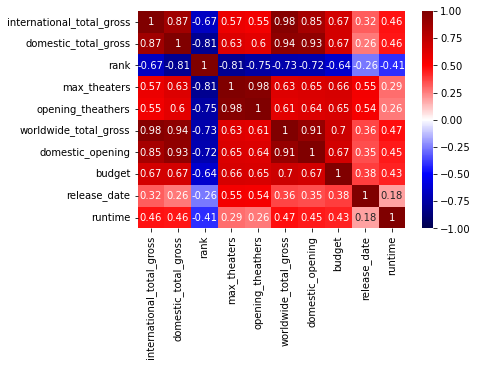

In [6]:
# heatmap
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


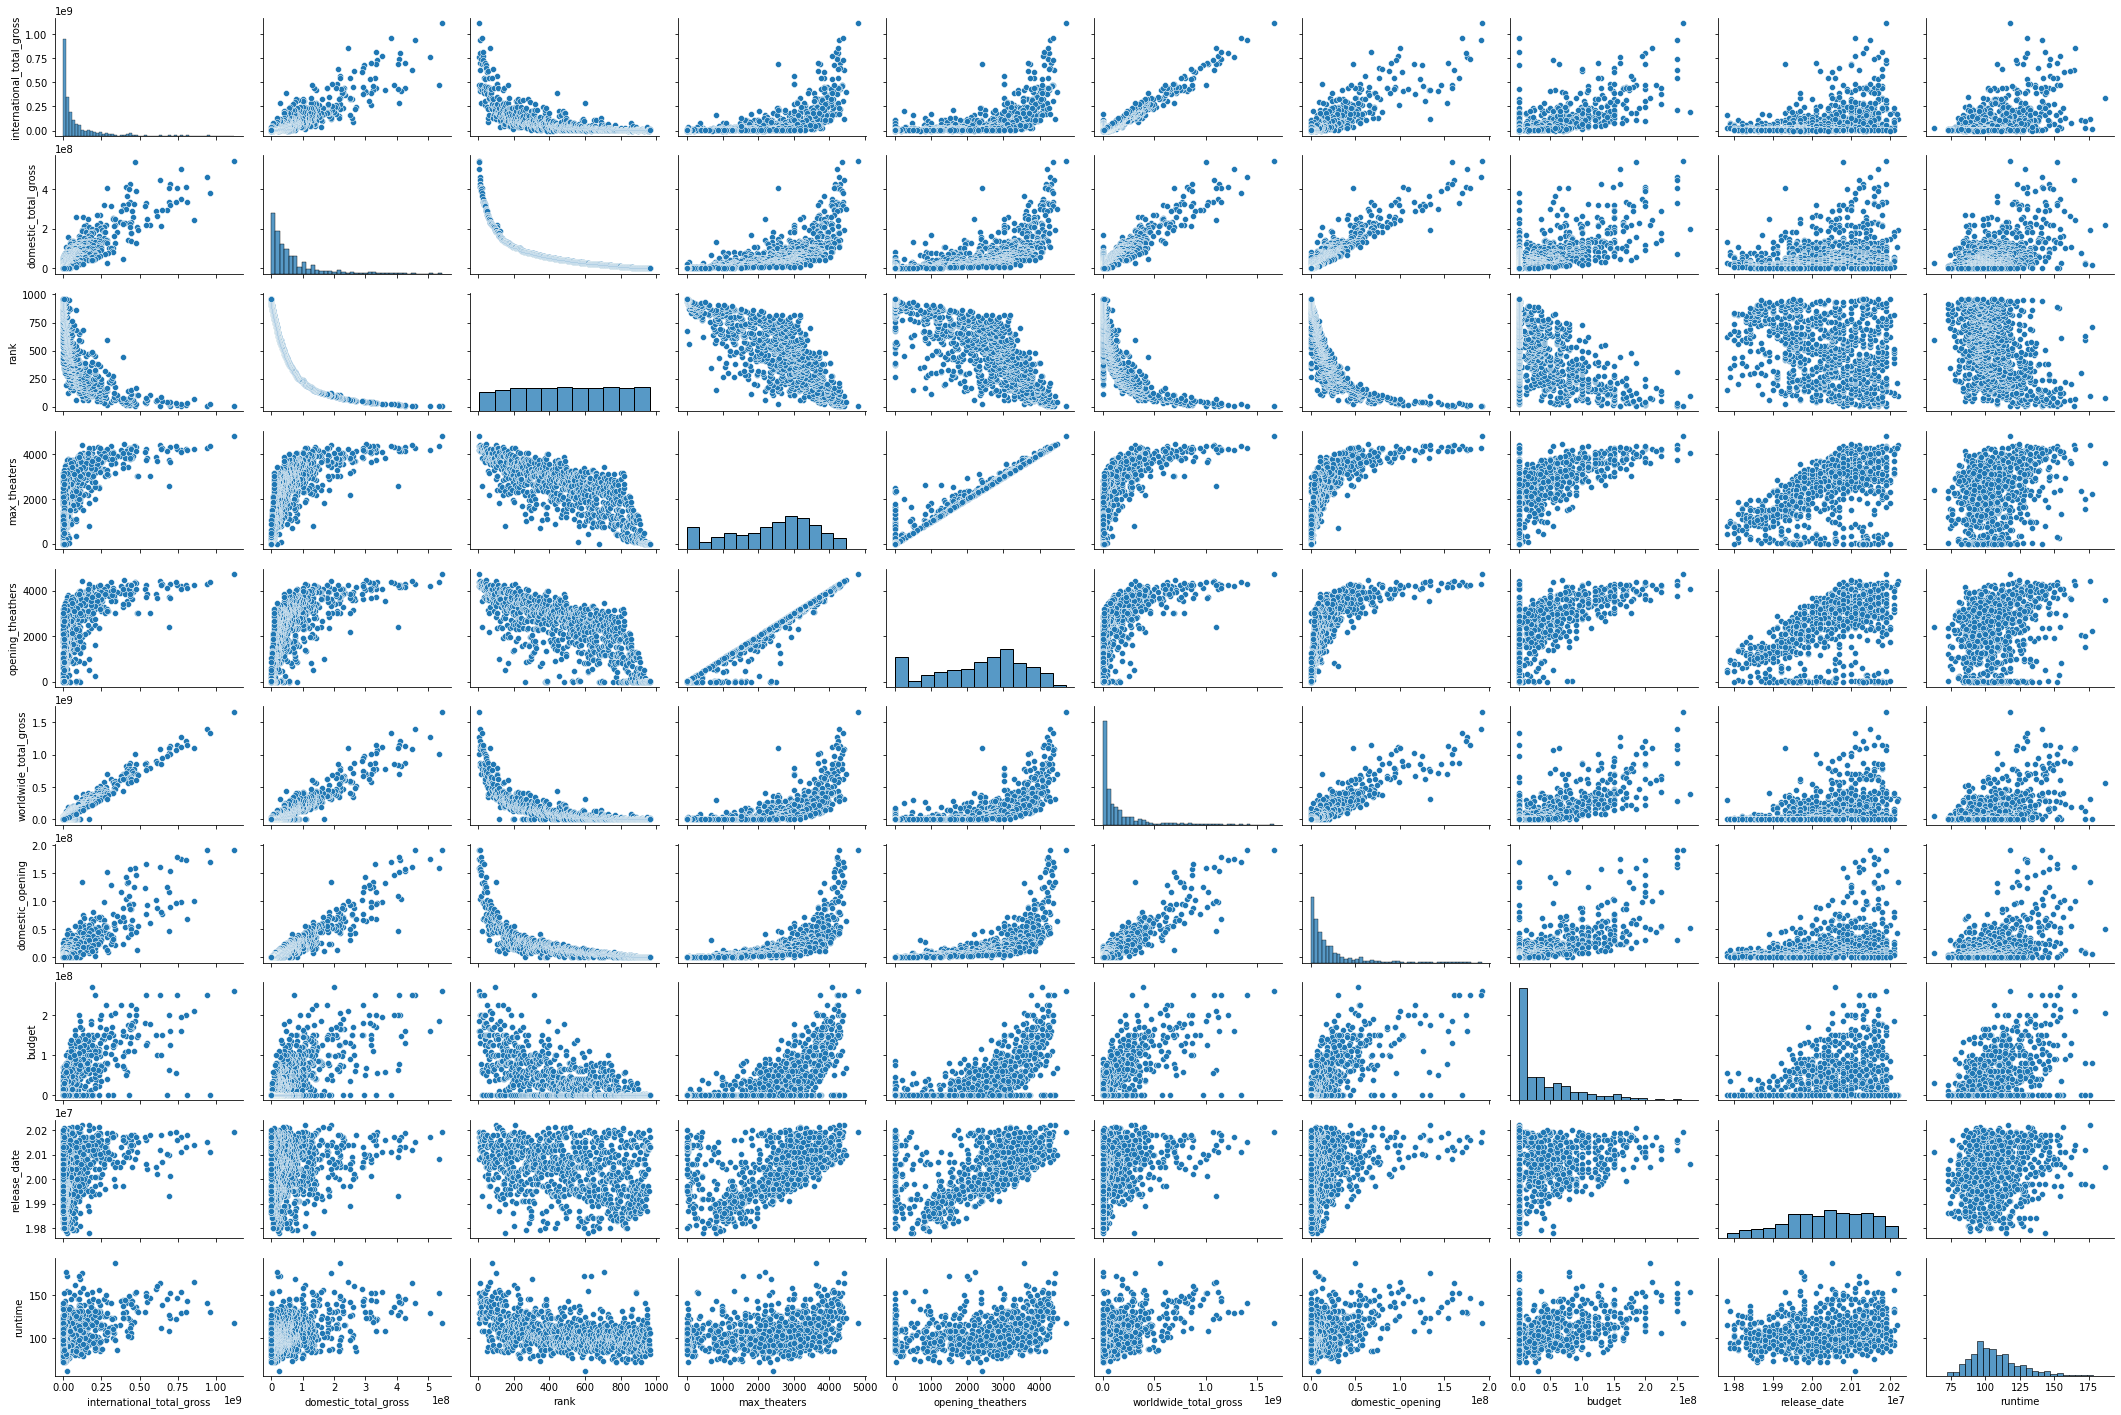

In [7]:
# pairplot
sns.pairplot(movie_df, height=2, aspect=1.5);

In [9]:
# correlation matrix
movie_df.corr()

# predictor = international_total_gross 
# predictor corrolated with (highest to lowest):
#     domestic_total_gross
#     domestic_opening
#     budget
#     max_theaters
#     opening_theathers
    
# Altohugh predictor and worldwide_total_gross highly corrolated, known multicollinearity.
# worldwide_total_gross = domestic_total_gross + international_total_gross


,international_total_gross,domestic_total_gross,rank,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime
international_total_gross,1.000000,0.873817,-0.671107,0.574093,0.554451,0.975968,0.850168,0.670195,0.319045,0.463650
domestic_total_gross,0.873817,1.000000,-0.810064,0.634118,0.604374,0.938414,0.932986,0.666972,0.261548,0.458144
rank,-0.671107,-0.810064,1.000000,-0.805333,-0.752380,-0.728856,-0.721033,-0.640095,-0.258546,-0.406675
max_theaters,0.574093,0.634118,-0.805333,1.000000,0.976059,0.627837,0.645794,0.661355,0.545525,0.285160
opening_theathers,0.554451,0.604374,-0.752380,0.976059,1.000000,0.605720,0.636875,0.651140,0.535674,0.259858
worldwide_total_gross,0.975968,0.938414,-0.728856,0.627837,0.605720,1.000000,0.907525,0.701654,0.359508,0.474908
domestic_opening,0.850168,0.932986,-0.721033,0.645794,0.636875,0.907525,1.000000,0.673557,0.347585,0.446373
budget,0.670195,0.666972,-0.640095,0.661355,0.651140,0.701654,0.673557,1.000000,0.382387,0.434988
release_date,0.319045,0.261548,-0.258546,0.545525,0.535674,0.359508,0.347585,0.382387,1.000000,0.184987
runtime,0.463650,0.458144,-0.406675,0.285160,0.259858,0.474908,0.446373,0.434988,0.184987,1.000000


### 3. Linear Regression Model

In [7]:
## FEAUTRES
# 'domestic_total_gross'
# 'domestic_opening'
# 'budget'
# 'max_theaters'
# 'opening_theathers'
# 'worldwide_total_gross' # wtg = domestic_total_gross + international_total_gross; candidate for multicollinearity

## TARGET
# 'international_total_gross'

# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening + budget + worldwide_total_gross', data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening + budget',                         data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening',                                  data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + budget',                                            data=movie_df, return_type="dataframe")
y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross',                                                     data=movie_df, return_type="dataframe")

# model
model = sm.OLS(y, X)

# fit model
fit = model.fit()

# model performance statistics
fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     international_total_gross   R-squared:                       0.764
Model:                                   OLS   Adj. R-squared:                  0.763
Method:                        Least Squares   F-statistic:                     2903.
Date:                       Sun, 13 Mar 2022   Prob (F-statistic):          9.44e-284
Time:                               20:05:33   Log-Likelihood:                -17572.
No. Observations:                        901   AIC:                         3.515e+04
Df Residuals:                            899   BIC:                         3.516e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.173e+07   3.06e+06     -3.831      0.000   -1.77e+07   -5.72e+06
domestic_total_gross     1.5312      0.028     53.881      0.000       1.475       1.587
==============================================================================
Omnibus:                      281.523   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2517.116
Skew:                           1.158   Prob(JB):                         0.00
Kurtosis:                      10.854   Cond. No.                     1.38e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. Model Visualization


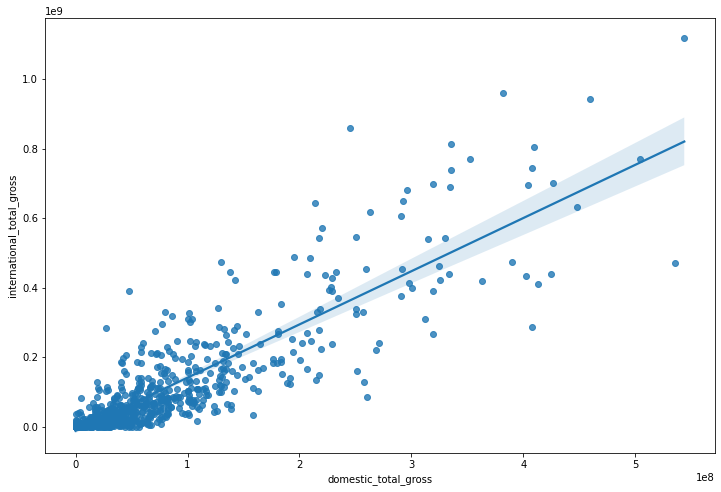

In [8]:
# linear regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);


### 5. Residuals Plot

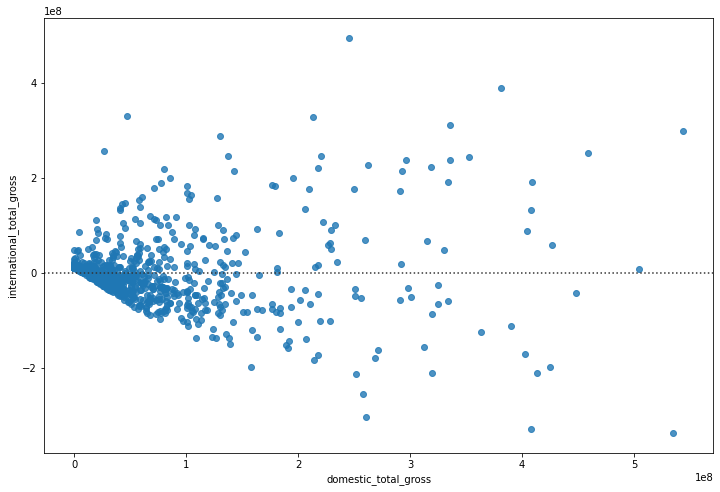

In [9]:
# cone shape indicates heteroskedasticity; likely due to the large range of domestic movie revenue
f, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);
